# 주택 가격 예측

- 캘리포니아 인구조사 데이터를 사용해 캘리포니아 주택 가격 모델을 만드는 것이 목표
- 이 데이터는 캘리포니아의 블록 그룹 마다 인구, 중간 소득, 중간 주택 가격 등을 담고 있다.
- 블록 그룹은 미국 인구조사국에서 샘플 데이터를 발표하는 데 사용하는 최소한의 지리적 단위
- 하나의 블록 그룹은 보통 600 ~ 3000명의 인구를 나타낸다.
- 이 데이터로 모델을 학습시켜서 다른 측정 데이터가 주어졌을 때 구역의 중간 주택 가격을 예측해보자.

### 2.2.1 문제정의

- 상사에게 첫 번째로 할 질문은 비즈니스 목적이 정확히 무엇인가요?다.
- 모델 만들기가 최종 목적은 아닐 것이다.

- 다음 질문은 현재 솔루션은 어떻게 구성되어 있나요? 다.|

- 이런 정보들을 가지고 시스템을 설계할 준비를 한다.
- 먼저 문제를 정의해야 한다.
- 지도, 비지도, 강화 학습?
- 분류나 회귀?
- 배치, 온라인 학습?

- 레이블된 훈련 샘플이 있으니 전형적인 지도 학습 작업
    - 각 샘플이 기대 출력값, 즉 구역의 중간 주택 가격을 가지고 있다.
- 값을 예측해야 하므로 회귀 문제
    - 예측에 사용할 특성이 여러 개이므로 대변량 회귀(multivariate regression)
- 시스템으로 들어오는 데이터에 연속적인 흐름이 ㅇ없으므로 빠르게 변하는 데이터에 적응하지 않아도 되고, 데이터가 메모리에 들어갈만큼 충분히 작으므로 일반적인 배치 학습이 적절하다.

### 2.2.2 성능 측정 지표 선택

- 회귀 문제의 전형적인 성능 지표는 평균 제곱근 오차(Root Mean Square Error RMSE)
- 오차가 커질수록 이 값은 더욱 커지므로 예측에 얼마나 많은 오류가 있는지 가늠할 수 있다.
- RMSE가 일반적으로 회귀 문제에 선호되는 성능 측정 방법이지만 경우에 따라 다른 함수를 사용할 수도 있다.
- 이상치로 보이는 구역이 많을 경우 평균 절대 오차(Mean Absolute Error)를 고려해볼 수 있다.

- RMSE, MAE 모두 예측값의 벡터와 타깃값의 벡터 사이의 거리를 재는 방법이다.
- 거리 측정에는 여러 가지 방법(norm)이 가능하다.

- 제곱항을 합한 것의 제곱근(RMSE) 계산은 유클리디안 노름에 해당한다.
- 우리와 친숙한 거리 개념

- 노름의 지수가 클수록 큰 값의 원소에 치우치며 작은 값은 무시된다.
- 그래서 RMSE가 MAE보다 조금 더 이상치에 민감하다.
- 하지만 종 모양 분포의 양 끝단처럼 이상치가 매우 드물면 RMSE가 잘 맞아 일반적으로 널리 사용된다.

#### 표기법

- m은 RMSE를 측정할 데이터셋에 있는 샘플 수

### 2.3.3 데이터 구조 훑어보기

In [1]:
import os
import numpy as np
import pandas as pd
from pandas import DataFrame, Series

In [2]:
def load_housing_data(housing_path='./data/'):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

In [3]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.shape

(20640, 10)

In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.5+ MB


- ocean_proximity 필드만 빼고 모든 특성이 숫자
- 동일한 값이 반복되는것으로 보아 이 categorical type으로 추정
- value_counts() 메소드로 확인

In [6]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

- describe() 메서드는 숫자 type 특성의 요약정보를 출력한다.

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


- 백분위수는 전체 관측값에서 주어진 백분율이 속하는 하위 부분의 값을 나타낸다.
- 예를 들어 housing_median_age의 25%는 18보다 작고, 50%는 29보다 작다는 것을 의미한다.
- 25%를 제1사분위수, 중간값, 75%를 제3사분위수 라고 한다.

- 데이터의 형태를 빠르게 검토하는 다른 방법은 숫자 type을 히스토그램으로 그려보는 것이다.

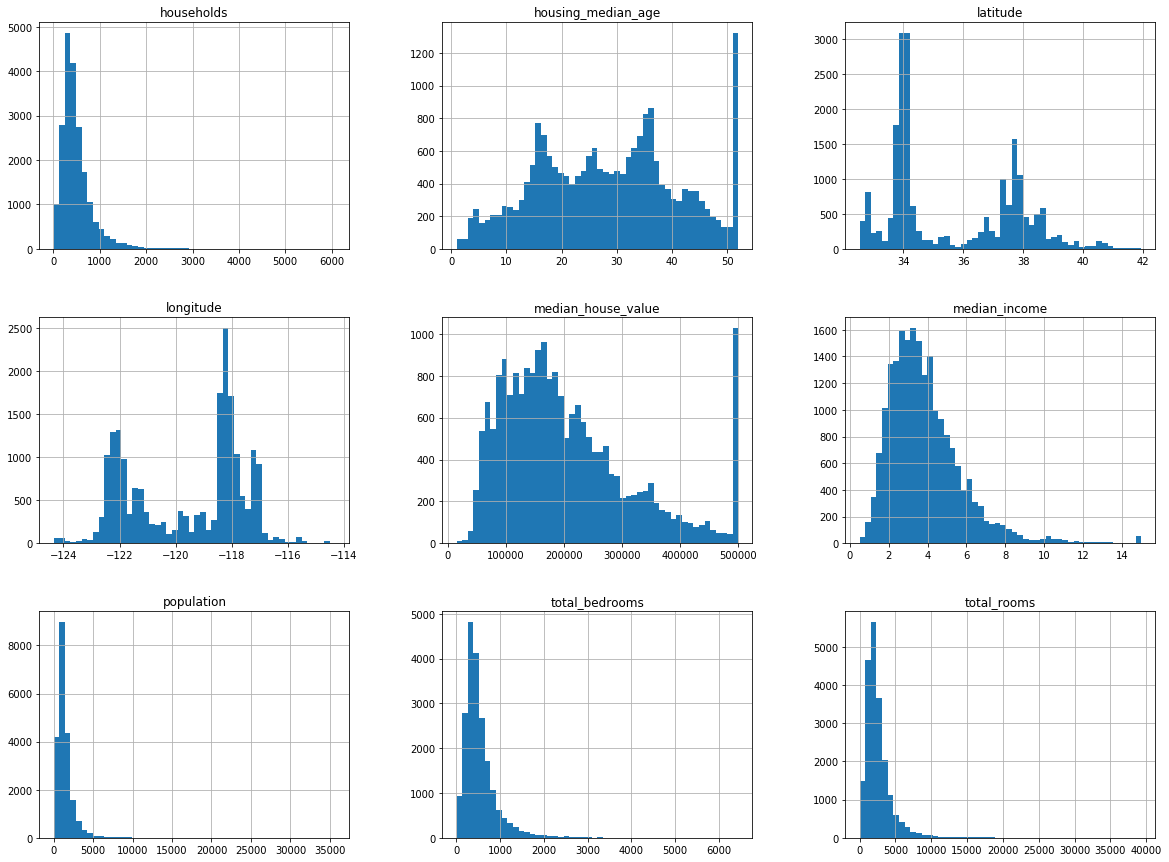

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20, 15))
plt.show()

### 2.3.4 테스트 세트 만들기

- 테스트 세트를 들여다본다면 테스트 세트에서 겉으로 드러난 어떤 패턴에 속아 특정 머신러닝 모델을 선택하게 될지도 모른다.

In [9]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [10]:
train_set, test_set = split_train_test(housing, 0.2)

In [11]:
len(train_set), len(test_set)

(16512, 4128)

- 사이킷런은 데이터셋을 여러 서브셋으로 나누는 다양한 방법을 제공한다.
- 가장 간단한 함수는 train_test_split
- 두 가지 특징
- 난수 초기값을 지정할 수 있는 random_state 매개변수
- row의 개수가 같은 여러 개의 데이터셋을 넘겨서 같은 인덱스를 기반으로 나눌 수 있다.
    - DataFrame이 레이블에 따라 여러 개로 나뉘어 있을 때 유용하다.

In [12]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

- 지금까지는 순수한 무작위 샘플링 방식
- 데이터셋이 특성 수에 비해 충분히 크다면 괜찮지만, 그렇지 않다면 샘플링 편향이 생길 가능성이 크다.

- 계층적 샘플링 stratified sampling
- 전체 모수는 계층strata 이라는 동질의 그룹으로 나뉘고, 테스트 세트가 전체 모수를 대표하도록 각 계층에서 올바른 수의 샘플을 추출한다.

In [13]:
housing['income_cat'] = np.ceil(housing['median_income'] / 1.5)
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace=True)

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [15]:
housing['income_cat'].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [16]:
strat_train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN,2.0
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN,5.0
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN,2.0
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND,2.0
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN,3.0


In [17]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

In [18]:
strat_train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN


## 2.4 데이터 이해를 위한 탐색과 시각화

- 훈련 세트를 손상시키지 않기 위해 복사본을 만들어 사용한다.

In [19]:
housing = strat_train_set.copy()

### 2.4.1 지리적 데이터 시각화

- 지리 정보가 있으니 모든 구역을 산점도로 만들어 데이터를 시각화한다.

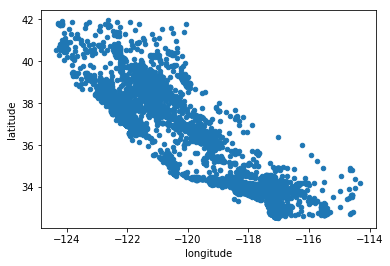

In [20]:
housing.plot(kind='scatter', x='longitude', y='latitude')

- 캘리포니아 지역을 나타내지만 어떤 특별한 패턴을 찾기는 힘들다
- alpha 옵션을 0.1로 주면 데이터 포인트가 밀집된 영역을 볼 수 있다.

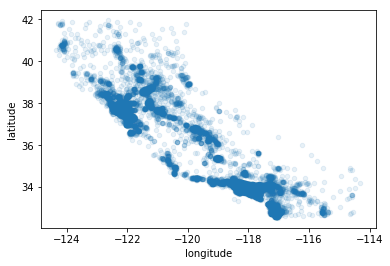

In [21]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

- 주택 가격을 표시해본다.
- 원의 반지름은 구역의 인구
- 색깔은 가격, 파란색 낮은 가격 빨간색 높은 가격

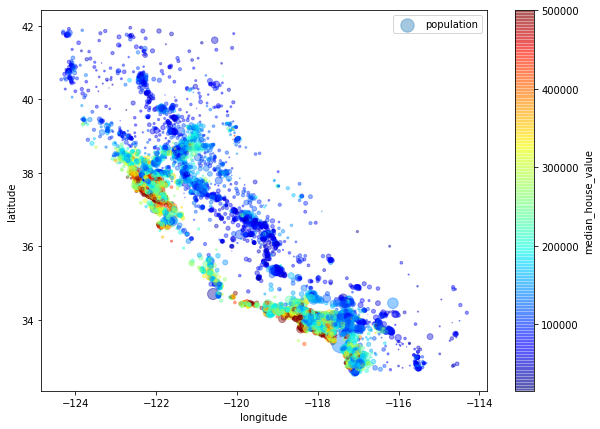

In [22]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
             s=housing['population']/100, label='population', figsize=(10, 7),
             c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True, sharex=False)
plt.legend()

### 2.4.2 상관관계 조사

- 데이터셋이 너무 크지 않으므로 모든 특성 간의 표준 상관 계수(standard correlation coefficient)를 corr() 메서드를 이용하여 쉽게 계산할 수 있다.
- 중간 주택 가격과 다른 특성 사이의 상관관계 크기를 확인해보자.

In [23]:
corr_matrix = housing.corr()

In [24]:
corr_matrix.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689


In [25]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

- 상관관계의 범위는 -1부터 1까지
- 1에 가까우면 강한 양의 상관관계를 가진다는 뜻
- median_house_value는 modian_income이 올라갈 때 증가하는 경향이 있다.
- 계수가 -1에 가까우면 강한 음의 상관관계를 나타낸다.
- 위도 latitude와 median_house_value 사이에는 약한 음의 상관관계가 보인다.
- 계수가 0에 가까우면 선형적인 상관관계가 없다는 의미

- 상관계수는 선형적인 상관관계만 측정한다.(x가 증가하면 y는 증가하거나 감소한다.)

- 특성 사이의 상관관계를 확인하는 다른 방법은 숫자 type 특성 사이에 산점도를 그려주는 pandas의 scatter_matrix 함수를 사용하는 것이다.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11A09570>,
      dtype=object)

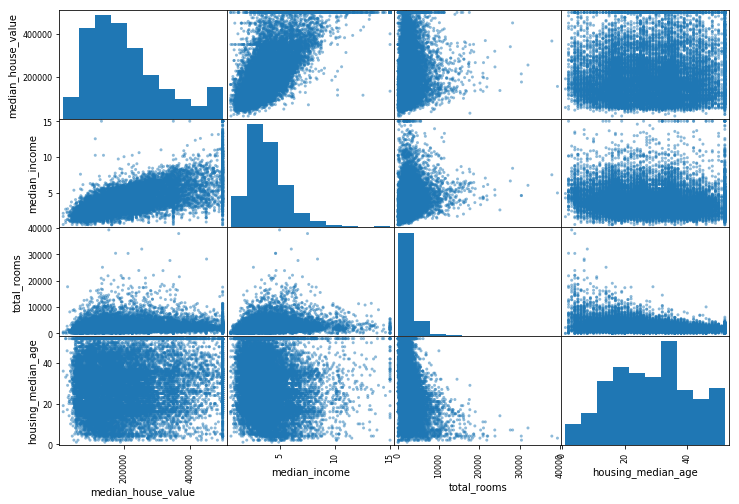

In [26]:
from pandas .plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize=(12, 8))

- scatter_matrix 메서드의 diagonal 매개변수에 히스토드램을 나타내는 hist와 커널 밀도 추정(kernel density estimation)을 나타내는 kde를 지정할 수 있다.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0E04D050>,
      dtype=object)

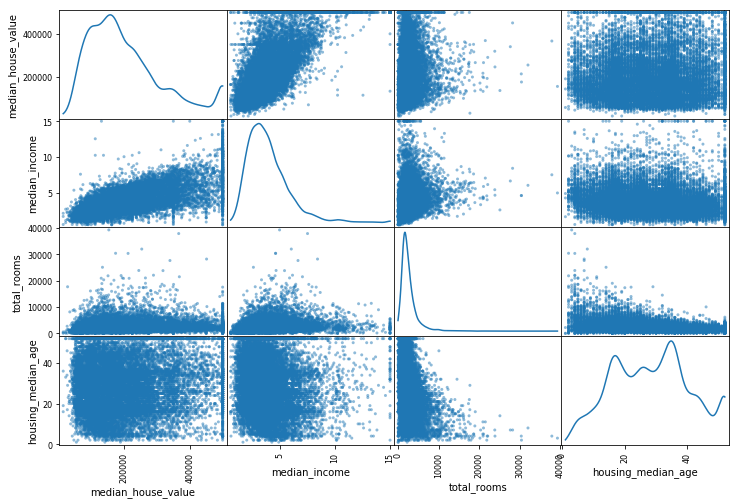

In [27]:
from pandas .plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize=(12, 8), diagonal='kde')

- median_house_value를 예측하는 데 가장 유용할 것 같은 특성은 median_income이므로 상관관계 산점도를 확대해보자.

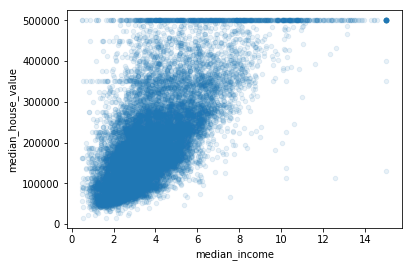

In [28]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)

- 이 그래프로 다음과 같은 사실을 알 수 있다.
- 1.상관관계가 매우 강하다.
    - 위쪽으로 향하는 경향을 볼 수 있고 포인트들이 너무 널리 퍼져 있지 않다.
- 2.위쪽 수평선, 중간 수평선
    - 알고리즘이 데이터에서 이런 이상한 형태를 학습하지 않도록 해당 구역을 제거하는 것이 좋다.   

### 2.4.3 특성 조합으로 실험

- 머신러닝 알고리즘용 데이터를 실제로 준비하기 전에 마지막으로 해볼 수 있는 것은 여러 특성의 조합을 시도해 보는 것.
- 가구당 방 개수, 방 개수당 침대 개수, 가구당 인원 등

In [29]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"]=housing["population"] / housing["households"]

- col을 추가했으니 상관관계 행렬을 다시 확인해본다.

In [30]:
corr_matrix = housing.corr()

In [31]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

- bedrooms_per_room 특성은 전체 

## 2.5 머신러닝 알고리즘을 위한 데이터 준비

- 데이터 준비를 수작업이 아니라 함수를 만들어 자동화해야 하는 이유
- 어떤 데이터셋에 대해서도 데이터 변환을 손쉽게 반복할 수 있다.
- 향흥 프로젝트에 사용할 수 있는 변환 라이브러리를 점진적으로 구축하게 된다.
- 실제 시스템에서 알고리즘에 새 데이터를 주입하기 전에 변환시키는데 이 함수를 사용할 수 있다.
- 여러 가지 데이터 변환을 쉽게 시도해볼 수 있고 어떤 조합이 가장 좋은지 확인하는데 편리하다.